<a href="https://colab.research.google.com/github/Jorge-Suarez-Linares/Machine-Learning-Deep-Learning--DataScience_Portfolio/blob/main/Progetto_Toxic_Comments_Filter(DNN%20-%20LLM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project: Toxic Comment Filter

[ENG] This model aims to filter user comments based on the degree of language toxicity. It preprocesses the text by removing tokens that do not contribute significantly to semantic meaning, transforms the textual corpus into sequences, and constructs a Deep Learning model with recurrent layers for a multilabel classification task. The number of neurons used is limited on purpose ( avoid excessive RAM usage)


[ITA]Questo modello ha lo scopo di filtrare i commenti degli utenti in base al grado di tossicità del linguaggio. Preelabora il testo rimuovendo i token che non contribuiscono significativamente al significato semantico, trasforma il corpus testuale in sequenze e costruisce un modello di Deep Learning con layer ricorrenti per un compito di classificazione multilabel. Il numero di neuroni utilizzato è volontariamente limitato. ( per non sovraccaricare troppo la RAM)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional,  LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.backend import clear_session
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.losses import categorical_crossentropy
from keras.layers import Dropout, BatchNormalization

In [ ]:
import pandas as pd
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

In [ ]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [ ]:
df = df.drop('sum_injurious', axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


In [ ]:
len(df)

159571

In [ ]:
clear_session()

In [ ]:
X = df['comment_text' ]
y = df.drop('comment_text', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
X_train, X_val, y_train,  y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

x_sequences_train = tokenizer.texts_to_sequences(X_train)
x_sequences_test = tokenizer.texts_to_sequences(X_test)

vocab = len(tokenizer.word_index)+1

maxlen = len(max(x_sequences_train))

padded_xsequences_train = pad_sequences(x_sequences_train, maxlen = maxlen)
padded_xsequences_test= pad_sequences(x_sequences_test, maxlen = maxlen)

In [ ]:

model = Sequential()
model.add(Embedding(vocab, 250, input_length=maxlen))
model.add(Bidirectional(LSTM(250, return_sequences=True, recurrent_dropout =0.5, go_backwards=True, activation='tanh')))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(150, return_sequences=True, recurrent_dropout =0.5 , activation='tanh')))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(75,return_sequences=True, recurrent_dropout =0.5,  activation='tanh')))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(30, recurrent_dropout =0.5, activation='tanh')))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

questo sotto ha lassciato dei risultati che ci possono stare visivamente

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 250)           36576250  
                                                                 
 bidirectional (Bidirection  (None, 25, 500)           1002000   
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 25, 500)           2000      
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 25, 300)           781200    
 onal)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 25, 300)           1200      
 chNormalization)                                       

In [ ]:
history = model.fit(padded_xsequences_train, y_train, validation_split =(y_train, y_val), epochs = 100, batch_size = 64, callbacks = [early_stopping])

Epoch 1/100
936/936 [==============================] - 1657s 2s/step - loss: 0.3344 - accuracy: 0.5305 - val_loss: 0.3574 - val_accuracy: 0.9537
Epoch 2/100
936/936 [==============================] - 1621s 2s/step - loss: 0.3606 - accuracy: 0.9473 - val_loss: 0.3782 - val_accuracy: 0.9447
Epoch 3/100
936/936 [==============================] - 1619s 2s/step - loss: 0.3713 - accuracy: 0.9501 - val_loss: 0.4101 - val_accuracy: 0.9181
Epoch 4/100
936/936 [==============================] - 1635s 2s/step - loss: 0.3815 - accuracy: 0.9537 - val_loss: 0.3971 - val_accuracy: 0.9559
Epoch 5/100
936/936 [==============================] - 1602s 2s/step - loss: 0.3772 - accuracy: 0.9528 - val_loss: 0.3883 - val_accuracy: 0.9539
Epoch 6/100
936/936 [==============================] - 1645s 2s/step - loss: 0.3763 - accuracy: 0.9522 - val_loss: 0.3914 - val_accuracy: 0.9476


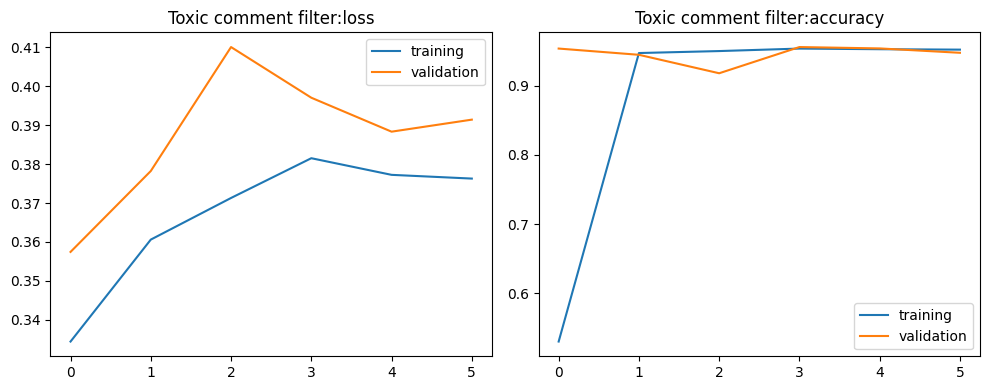

In [ ]:
plot_learning_curves(history, 'Toxic comment filter')

In [ ]:
model.evaluate(padded_xsequences_test, y_test)

1496/1496 [==============================] - 281s 188ms/step - loss: 0.3627 - accuracy: 0.9528


[0.3626912534236908, 0.9527698755264282]

In [ ]:
sentence_pred= input()
sequences_pred = tokenizer.texts_to_sequences(sentence_pred)


padded_xsequences_pred = pad_sequences(sequences_pred, maxlen=maxlen)


prediction = model.predict(padded_xsequences_pred)
print(prediction)

predicted_labels = threshold_binary(prediction, threshold=0.4)
print(predicted_labels)

In [ ]:
def threshold_binary(pred, threshold=0.3):
    predicted_labels = []
    for prob_row in pred:
        labels_row = [1 if prob >= threshold else 0 for prob in prob_row]
        predicted_labels.append(labels_row)
    return predicted_labels

In [ ]:
def plot_learning_curves(hist,exp_name):
    plt.figure(figsize=(10,4))
    for subplot,curve in enumerate(['loss','accuracy']):
        plt.subplot(1,2,subplot+1)
        plt.plot(hist.history[curve],label='training')
        plt.plot(hist.history['val_'+curve],label='validation')
        plt.legend()
        plt.title(exp_name+':'+curve)
    plt.tight_layout();